In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math
import os

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.RandomAdjustSharpness(0.25),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
root = 'data/birds1/'
data_dirs = os.listdir(root)
data_dirs = np.array(data_dirs)
data_dirs = data_dirs.flatten()

roots = np.array([root] * len(data_dirs))
data_dirs = np.core.defchararray.add(roots, data_dirs)

# data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.9 * len(data_dirs))
val_split = math.ceil(0.05 * len(data_dirs))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)

(3202, 178, 178)

In [3]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = in_data
        # self.labels = data[:, 1]
        self.labels = []
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.input_dirs)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        # labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, transformed, inputs
        else:
            return inputs, inputs, inputs

In [4]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=(transform, transform))
    val_data = GenData(data_dirs[val.indices], transform=(transform, transform))
    test_data = GenData(data_dirs[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader


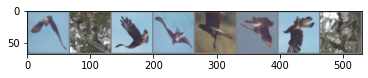

In [39]:
'''Code to visualize the data in the training set'''

import torchvision

def imsave(inp, savename=None, title=None):
    """Display image for Tensor."""
    inp = torchvision.utils.make_grid(inp)
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imsave(f'pics/{savename}.png', inp)
    # if title is not None:
    #     plt.title(title)
    # plt.pause(0.001)  # pause a bit so that plots are updated

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(8)
inputs, _, _ = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x.item()] for x in classes])
imshow(out)

In [6]:
'''
Helper functions (based off of previous labs)
'''
def get_model_name(name, batch_size, learning_rate, momentum, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_m{3}_epoch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   momentum,
                                                   epoch)
    return path


# Training Curve
def plot_loss_curve(train_gen_loss, train_disc_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    n = len(train_gen_loss) # number of iterations
    plt.title("Generator Loss vs Discriminator Loss")
    plt.plot(range(1,n+1), train_gen_loss, label="Gen Loss")
    plt.plot(range(1,n+1), train_disc_loss, label="Disc Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [7]:
class GAN(nn.Module):
    def __init__(self, latentDim = 100, featureGen = 64, featureDisc = 64):
        super().__init__()

        self.generator == nn.Sequential(
            # latentDim x 1 x 1 -> featureGen * 8 x 4 x 4
            nn.ConvTranspose2d(latentDim, featureGen * 8, kernel_size = 4,
                                stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(featureGen * 8),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureGen * 8 x 4 x 4 -> featureGen * 4 x 8 x 8
            nn.ConvTranspose2d(featureGen * 8, featureGen * 4, kernel_size = 4,
                                stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(feautreGen * 4),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            #  featureGen * 4 x 8 x 8 -> featureGen * 2 x 16 x 16
            nn.ConvTranspose2d(featureGen * 4, featureGen * 2, kernel_size = 4,
                                stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(feautreGen * 2),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureGen * 2 x 16 x 16 -> featureGen x 32 x 32
            nn.ConvTranspose2d(featureGen * 2, featureGen, kernel_size = 4,
                                stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(feautreGen),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureGen x 32 x 32 -> 3 x 64 x 64
            nn.ConvTranspose2d(featureGen, 3, kernel_size = 4,
                                stride = 2, padding = 1, bias = False),
        
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            # 3 x 64 x 64 -> featureDisc x 32 x 32
            nn.Conv2d(3, featureDisc, kernel_size = 4,
                        stride = 2, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureDisc x 32 x 32 -> featureDisc * 2 x 16 x 16
            nn.Conv2d(featureDisc, featureDisc * 2, kernel_size = 4,
                        stride = 2, padding = 1),
            nn.BacthNorm2d(featureDisc * 2),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureDisc * 2 x 16 x 16 -> featureDisc * 4 x 8 x 8
            nn.Conv2d(featureDisc * 2, featureDisc * 4, kernel_size = 4,
                        stride = 2, padding = 1),
            nn.BacthNorm2d(featureDisc * 4),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureDisc * 4 x 8 x 8 -> featureDisc * 8 x 4 x 4
            nn.Conv2d(featureDisc * 4, featureDisc * 8, kernel_size = 4,
                        stride = 2, padding = 1),
            nn.BacthNorm2d(featureDisc * 8),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),

            # featureDisc * 8 x 4 x 4 -> 1 x 1 x 1
            nn.Conv2d(featureDisc * 8, 1, kernel_size = 4,
                    stride = 1, padding = 0),
                    
            nn.Flatten()
        )

    def genForward(self, x):
        return self.generator(x)

    def discForward(self, img):
        return self.discriminator(img)

In [8]:
def train_discriminator(model, inputs, latent_dim, criterion):
  batchSize = inputs.size(0)

  real_images = inputs.to(device)
  realLabels = torch.ones(batchSize, device = device)

  noise = torch.randn(batchSize, latent_dim, 1, 1, device = device)
  fake_images = model.genForward(noise)
  fakeLabels = torch.zeros(batchSize, device = device)

  discPredReal = model.discForward(real_images).view(-1)
  realLoss = criterion(discPredReal, realLabels)

  discPredFake = model.discForward(fake_images).view(-1)
  fakeLoss = criterion(discPredFake, fakeLabels)

  discLoss = 0.5 * (realLoss + fakeLoss)
  return realLabels, fakeLabels, fake_images, discLoss, discPredReal

In [9]:
def train_generator(model, inputs, realLabels, criterion):
  discPredFake = model.discForward(inputs).view(-1)
  genLoss = criterion(discPredFake, realLabels)

  return genLoss, discPredFake


In [46]:
'''
Train Loop
'''

import tqdm
import time
from torch.optim import lr_scheduler

OUTPUT_DIR = 'runs/'

def train_network(model, latent_dim, device, trainLoader, num_epochs, lr):

    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    # optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    gen_optimizer =  optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-3)
    disc_optimizer =  optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-3)


    # Training metrics
    train_gen_loss = []
    train_disc_loss = []
    train_disc_real_acc = []
    train_disc_fake_acc = []
    newImgs = []

    best_train_err = 1000
    best_val_err = 1000

    ########## SENDING TO CUDA ############
    if cuda:
        generator = generator.to('cuda:0')
        discriminator = discriminator.to('cuda:0')

    start_time = time.time()

    # Train loop
    for epoch in range(num_epochs):
        model.train()
        iteration = 0
        for imgs, _ in trainLoader: 

            realLabels, fakeLabels, fake_images, discLoss, discPredReal = train_discriminator(model, imgs, latent_dim, criterion)
            discLoss.backward()
            disc_optimizer.step()
            disc_optimizer.zero_grad()

            genLoss, discPredFake = train_generator(model, fake_images, realLabels, criterion)
            genLoss.backward()
            gen_optimizer.step()
            gen_optimizer.zero_grad()
                
            predReal = torch.where(discPredReal.detach() > 0.0, 1.0, 0.0)
            predFake = torch.where(discPredFake.detach() > 0.0, 1.0, 0.0)
            accReal = (predReal == realLabels).float().mean() * 100
            accFake = (predFake == fakeLabels).float().mean() * 100

            train_gen_loss.append(genLoss.item())
            train_disc_loss.append(discLoss.item())
            train_disc_real_acc.append(accReal.item())
            train_disc_fake_acc.append(accFake.item())

            iteration += 1

            if(iteration % interval == 0):
                print("Epoch: %03d/%03d | Batch %03d/%03d | Gen/Disc Loss: %.4f/%.4f"
                        % (epoch + 1, num_epochs, iteration, len(trainLoader), 
                            genLoss.item(), discLoss.item()))
        newImgs.append(torchvision.utils.make_grid(fake_images, padding = 2, normalzie = True))
        print("Time elapsed: %.2f min" % ((time.time() - start_time) / 60))
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    return train_gen_loss, train_disc_loss, train_disc_real_acc, train_disc_fake_acc, newImgs



In [44]:
gan_model = GAN(latentDim = 100, featureGen = 64, featureDisc = 64)
gan_model.name = 'gan'
trainLoader, valLoader, testLoader = get_data_loaders(batch_size=64)

In [47]:
batch = 64
lr = 0.007
m = 0.9
epochs = 500

train_gen_loss, train_disc_loss, train_disc_real_acc, train_disc_fake_acc, newImgs =
train_network(gan_model, 100, device = DEVICE, trainLoader, num_epochs = epochs, lr = lr)
model_path =  OUTPUT_DIR + get_model_name(gan_model.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

  0%|          | 1/500 [00:19<2:38:15, 19.03s/it]

Epoch 0: Gen Train Loss: 29097403.108580347, Disc Train Loss: 0.2159889082060587 |
 Gen Val Loss: 377763.0625, Disc Val Loss: 9.593592115682744e-06


  0%|          | 2/500 [00:37<2:33:18, 18.47s/it]

Epoch 1: Gen Train Loss: 409570.67095588235, Disc Train Loss: 0.0032139749753886692 |
 Gen Val Loss: 334243.3541666667, Disc Val Loss: 0.00027860404225066304


  1%|          | 3/500 [00:55<2:33:09, 18.49s/it]

Epoch 2: Gen Train Loss: 391751.4074754902, Disc Train Loss: 0.00030081143703165593 |
 Gen Val Loss: 330440.3541666667, Disc Val Loss: 7.941416697576642e-05


  1%|          | 4/500 [01:21<2:56:39, 21.37s/it]

Epoch 3: Gen Train Loss: 5108638.6875, Disc Train Loss: 0.0001561044112296419 |
 Gen Val Loss: 376984.9166666667, Disc Val Loss: 4.3597688393977783e-05


  1%|          | 5/500 [01:43<2:59:18, 21.74s/it]

Epoch 4: Gen Train Loss: 572164.3400735294, Disc Train Loss: 0.040952617627128735 |
 Gen Val Loss: 406148.4479166667, Disc Val Loss: 8.47627295759897e-08


  1%|          | 6/500 [02:04<2:55:36, 21.33s/it]

Epoch 5: Gen Train Loss: 390803.6574754902, Disc Train Loss: 0.0002676265030890237 |
 Gen Val Loss: 1162723.5208333333, Disc Val Loss: 5.694873692618785e-07


  1%|▏         | 7/500 [02:21<2:45:11, 20.10s/it]

Epoch 6: Gen Train Loss: 616196.2849264706, Disc Train Loss: 2.1311554712304305e-05 |
 Gen Val Loss: 392670.0833333333, Disc Val Loss: 7.044515465774263e-07


  2%|▏         | 8/500 [02:41<2:44:20, 20.04s/it]

Epoch 7: Gen Train Loss: 446339.92156862747, Disc Train Loss: 0.00032808773251720896 |
 Gen Val Loss: 434258.5, Disc Val Loss: 8.269674071925692e-05


  2%|▏         | 9/500 [02:59<2:38:58, 19.43s/it]

Epoch 8: Gen Train Loss: 1036980.0171568628, Disc Train Loss: 2.4211312009748664e-05 |
 Gen Val Loss: 448823.2916666667, Disc Val Loss: 2.2976829010682803e-05


  2%|▏         | 10/500 [03:19<2:39:19, 19.51s/it]

Epoch 9: Gen Train Loss: 486825.7708333333, Disc Train Loss: 0.035771987815928254 |
 Gen Val Loss: 455815.6666666667, Disc Val Loss: 0.17665529747804007


  2%|▏         | 11/500 [03:41<2:44:15, 20.15s/it]

Epoch 10: Gen Train Loss: 195007398.40931374, Disc Train Loss: 0.01291850242848216 |
 Gen Val Loss: 526871.5104166666, Disc Val Loss: 0.00020991348719689995


  2%|▏         | 12/500 [03:58<2:37:07, 19.32s/it]

Epoch 11: Gen Train Loss: 1710331.0484068627, Disc Train Loss: 0.000159203049477975 |
 Gen Val Loss: 498729.4791666667, Disc Val Loss: 0.00012344693338188031


  3%|▎         | 13/500 [04:15<2:32:00, 18.73s/it]

Epoch 12: Gen Train Loss: 27176594.52512255, Disc Train Loss: 9.38843142791359e-05 |
 Gen Val Loss: 1058627.6666666667, Disc Val Loss: 7.046164197769637e-05


  3%|▎         | 14/500 [04:35<2:33:29, 18.95s/it]

Epoch 13: Gen Train Loss: 7174549.711397059, Disc Train Loss: 6.278934483370725e-05 |
 Gen Val Loss: 532609.6458333334, Disc Val Loss: 6.159655458759516e-05


  3%|▎         | 15/500 [04:57<2:39:56, 19.79s/it]

Epoch 14: Gen Train Loss: 806296.9865196078, Disc Train Loss: 5.9177147526426384e-05 |
 Gen Val Loss: 558281.6666666666, Disc Val Loss: 5.728336085060922e-05


  3%|▎         | 16/500 [05:14<2:33:32, 19.03s/it]

Epoch 15: Gen Train Loss: 21230509095364.68, Disc Train Loss: 5.4102695168123815e-05 |
 Gen Val Loss: 815174.0833333334, Disc Val Loss: 5.187668405900089e-05


  3%|▎         | 17/500 [05:30<2:26:42, 18.22s/it]

Epoch 16: Gen Train Loss: 1303627.7573529412, Disc Train Loss: 5.272291673463769e-05 |
 Gen Val Loss: 797225.4166666666, Disc Val Loss: 5.390795073860014e-05


  4%|▎         | 18/500 [05:47<2:22:45, 17.77s/it]

Epoch 17: Gen Train Loss: 27733492259720.484, Disc Train Loss: 5.789261879673337e-05 |
 Gen Val Loss: 942196.9583333334, Disc Val Loss: 6.13378676158997e-05


  4%|▍         | 19/500 [06:04<2:20:54, 17.58s/it]

Epoch 18: Gen Train Loss: 12774121.799019609, Disc Train Loss: 6.427892759686573e-05 |
 Gen Val Loss: 929456.3541666666, Disc Val Loss: 6.921681779203936e-05


  4%|▍         | 20/500 [06:22<2:20:40, 17.58s/it]

Epoch 19: Gen Train Loss: 1058758564.7193627, Disc Train Loss: 7.652792598545442e-05 |
 Gen Val Loss: 502561453.8333333, Disc Val Loss: 8.387841080548242e-05


  4%|▍         | 21/500 [06:40<2:21:13, 17.69s/it]

Epoch 20: Gen Train Loss: 15733386.045343136, Disc Train Loss: 9.136705250734939e-05 |
 Gen Val Loss: 3524513.6875, Disc Val Loss: 0.00010103577854655062


  4%|▍         | 22/500 [06:56<2:17:15, 17.23s/it]

Epoch 21: Gen Train Loss: 4764024233134.692, Disc Train Loss: 0.00010861932084891105 |
 Gen Val Loss: 1099109.125, Disc Val Loss: 0.00012193421328750749


  5%|▍         | 23/500 [07:11<2:11:06, 16.49s/it]

Epoch 22: Gen Train Loss: 88469069.10294117, Disc Train Loss: 0.0001293059350584871 |
 Gen Val Loss: 1980894.5416666667, Disc Val Loss: 0.00013549501212158552


  5%|▍         | 24/500 [07:27<2:10:22, 16.43s/it]

Epoch 23: Gen Train Loss: 1192502.5980392157, Disc Train Loss: 0.00015112852983578456 |
 Gen Val Loss: 1147048.25, Disc Val Loss: 0.00017229879934651157


  5%|▌         | 25/500 [07:44<2:10:44, 16.51s/it]

Epoch 24: Gen Train Loss: 1234986628.9264705, Disc Train Loss: 0.00018129859567053762 |
 Gen Val Loss: 1161754.4583333333, Disc Val Loss: 0.0001825705743006741


  5%|▌         | 26/500 [08:05<2:21:22, 17.89s/it]

Epoch 25: Gen Train Loss: 24024587.531862747, Disc Train Loss: 0.00020274616134188632 |
 Gen Val Loss: 417996412.125, Disc Val Loss: 0.0002168903301935643


  5%|▌         | 27/500 [08:26<2:28:18, 18.81s/it]

Epoch 26: Gen Train Loss: 9896757016.093138, Disc Train Loss: 0.00023676105917604895 |
 Gen Val Loss: 1294206.9583333333, Disc Val Loss: 0.00022277157889523855


  6%|▌         | 28/500 [08:48<2:35:24, 19.76s/it]

Epoch 27: Gen Train Loss: 137684113237.98038, Disc Train Loss: 0.0002438117480065272 |
 Gen Val Loss: 1134868.875, Disc Val Loss: 0.000294151104753837


  6%|▌         | 29/500 [09:09<2:38:27, 20.19s/it]

Epoch 28: Gen Train Loss: 7844890603.169118, Disc Train Loss: 0.00025406775553254226 |
 Gen Val Loss: 7144664.875, Disc Val Loss: 0.0002730813090844701


  6%|▌         | 30/500 [09:27<2:33:46, 19.63s/it]

Epoch 29: Gen Train Loss: 2.1765278044342296e+16, Disc Train Loss: 0.0002721665037896338 |
 Gen Val Loss: 1200454.375, Disc Val Loss: 0.00025650237027245265


  6%|▌         | 31/500 [09:46<2:31:05, 19.33s/it]

Epoch 30: Gen Train Loss: 45605660.10294118, Disc Train Loss: 0.000272463818820303 |
 Gen Val Loss: 125001224.79166667, Disc Val Loss: 0.00034018631170814234


  6%|▋         | 32/500 [10:06<2:33:55, 19.73s/it]

Epoch 31: Gen Train Loss: 10411776581.799019, Disc Train Loss: 0.0002917988544247825 |
 Gen Val Loss: 38672847677.541664, Disc Val Loss: 0.00028595417582740385


  7%|▋         | 33/500 [10:25<2:31:51, 19.51s/it]

Epoch 32: Gen Train Loss: 17077502084.72304, Disc Train Loss: 0.0002901413867149648 |
 Gen Val Loss: 1631775.4583333333, Disc Val Loss: 0.0002951412849749128


  7%|▋         | 34/500 [10:46<2:33:39, 19.78s/it]

Epoch 33: Gen Train Loss: 84774508.2254902, Disc Train Loss: 0.00029279133042448436 |
 Gen Val Loss: 1328999.7083333333, Disc Val Loss: 0.00029762464691884816


  7%|▋         | 35/500 [11:07<2:37:27, 20.32s/it]

Epoch 34: Gen Train Loss: 8373255026960.044, Disc Train Loss: 0.00029532366384313823 |
 Gen Val Loss: 1378749.0833333333, Disc Val Loss: 0.0002751498056265215


  7%|▋         | 36/500 [11:29<2:40:53, 20.81s/it]

Epoch 35: Gen Train Loss: 448922082144.799, Disc Train Loss: 0.00028778535631193106 |
 Gen Val Loss: 15925170.583333334, Disc Val Loss: 0.0002940804891598721


  7%|▋         | 37/500 [11:48<2:34:53, 20.07s/it]

Epoch 36: Gen Train Loss: 328559399.04901963, Disc Train Loss: 0.0002929111594544249 |
 Gen Val Loss: 1450871.8333333333, Disc Val Loss: 0.00031334229667360586


  8%|▊         | 38/500 [12:06<2:30:51, 19.59s/it]

Epoch 37: Gen Train Loss: 1.2858630627586002e+17, Disc Train Loss: 0.0002988153416891674 |
 Gen Val Loss: 5721670966.583333, Disc Val Loss: 0.0003011114022228867


  8%|▊         | 39/500 [12:25<2:27:35, 19.21s/it]

Epoch 38: Gen Train Loss: 19542505984.414215, Disc Train Loss: 0.00029595494361630843 |
 Gen Val Loss: 1802094.125, Disc Val Loss: 0.00031273656835158664


  8%|▊         | 40/500 [12:43<2:24:59, 18.91s/it]

Epoch 39: Gen Train Loss: 3995265471.497549, Disc Train Loss: 0.0002987671765617515 |
 Gen Val Loss: 1815431.625, Disc Val Loss: 0.0002842631268625458


  8%|▊         | 41/500 [13:01<2:23:34, 18.77s/it]

Epoch 40: Gen Train Loss: 81467995511.79167, Disc Train Loss: 0.00029897744603016795 |
 Gen Val Loss: 1758940.875, Disc Val Loss: 0.00033573078690096736


  8%|▊         | 42/500 [13:20<2:23:11, 18.76s/it]

Epoch 41: Gen Train Loss: 4832734520.063725, Disc Train Loss: 0.00029432942335238203 |
 Gen Val Loss: 1827688.125, Disc Val Loss: 0.00030896432387332123


  9%|▊         | 43/500 [13:38<2:21:36, 18.59s/it]

Epoch 42: Gen Train Loss: 7891813.946078432, Disc Train Loss: 0.0002979314018625255 |
 Gen Val Loss: 238705200.54166666, Disc Val Loss: 0.00029340631832989555


  9%|▉         | 44/500 [13:56<2:20:17, 18.46s/it]

Epoch 43: Gen Train Loss: 1897576.6789215687, Disc Train Loss: 0.00029874685295747924 |
 Gen Val Loss: 1836810.75, Disc Val Loss: 0.0002984727907460183


  9%|▉         | 45/500 [14:17<2:26:13, 19.28s/it]

Epoch 44: Gen Train Loss: 127369800375885.08, Disc Train Loss: 0.0002935524800491026 |
 Gen Val Loss: 1864748.2083333333, Disc Val Loss: 0.0002880167739931494


  9%|▉         | 46/500 [14:37<2:25:58, 19.29s/it]

Epoch 45: Gen Train Loss: 19966205.475490198, Disc Train Loss: 0.01433354589108474 |
 Gen Val Loss: 1829775.875, Disc Val Loss: 2.577597479103133e-05


  9%|▉         | 47/500 [14:55<2:23:03, 18.95s/it]

Epoch 46: Gen Train Loss: 12061086327.705883, Disc Train Loss: 4.323963652246212e-06 |
 Gen Val Loss: 1804364.25, Disc Val Loss: 3.9888562544850475e-06


 10%|▉         | 48/500 [15:14<2:22:52, 18.97s/it]

Epoch 47: Gen Train Loss: 406328507.3872549, Disc Train Loss: 1.100099608069571e-05 |
 Gen Val Loss: 257917575.375, Disc Val Loss: 2.420824481911647e-05


 10%|▉         | 49/500 [15:34<2:23:56, 19.15s/it]

Epoch 48: Gen Train Loss: 548246092.137255, Disc Train Loss: 4.189520551139425e-05 |
 Gen Val Loss: 1820055.625, Disc Val Loss: 6.212829612195492e-05


 10%|█         | 50/500 [15:52<2:22:08, 18.95s/it]

Epoch 49: Gen Train Loss: 257007353.49264705, Disc Train Loss: 6.543074285967604e-05 |
 Gen Val Loss: 1864993.0, Disc Val Loss: 7.08891335913601e-05


 10%|█         | 51/500 [16:12<2:23:12, 19.14s/it]

Epoch 50: Gen Train Loss: 2.3651376062626343e+20, Disc Train Loss: 7.976885050690423e-05 |
 Gen Val Loss: 1999410.75, Disc Val Loss: 8.744591226180394e-05


 10%|█         | 52/500 [16:30<2:20:22, 18.80s/it]

Epoch 51: Gen Train Loss: 1148937206.497549, Disc Train Loss: 9.703436052066037e-05 |
 Gen Val Loss: 1887903.125, Disc Val Loss: 0.00010606024200872828


 11%|█         | 53/500 [16:48<2:18:31, 18.59s/it]

Epoch 52: Gen Train Loss: 3607435.125, Disc Train Loss: 0.000151586313115652 |
 Gen Val Loss: 1862783.375, Disc Val Loss: 0.0006006414963242909


 11%|█         | 54/500 [17:06<2:17:36, 18.51s/it]

Epoch 53: Gen Train Loss: 6275993257.82598, Disc Train Loss: 0.00018866069648556375 |
 Gen Val Loss: 1887070.8333333333, Disc Val Loss: 0.0001670114870648831


 11%|█         | 55/500 [17:24<2:16:37, 18.42s/it]

Epoch 54: Gen Train Loss: 55482061720.73284, Disc Train Loss: 0.00017524411868733152 |
 Gen Val Loss: 1918998.7083333333, Disc Val Loss: 0.0002054367990543445


 11%|█         | 56/500 [17:44<2:18:23, 18.70s/it]

Epoch 55: Gen Train Loss: 196314291.88480392, Disc Train Loss: 0.0002151239162890752 |
 Gen Val Loss: 1967304.75, Disc Val Loss: 0.00023060178985664


 11%|█▏        | 57/500 [18:02<2:17:03, 18.56s/it]

Epoch 56: Gen Train Loss: 8.5342877630672e+24, Disc Train Loss: 0.0002472872934852015 |
 Gen Val Loss: 2010046.9166666667, Disc Val Loss: 0.0002666975681980451


 12%|█▏        | 58/500 [18:22<2:19:38, 18.96s/it]

Epoch 57: Gen Train Loss: 347949208.27205884, Disc Train Loss: 0.00031201570242296394 |
 Gen Val Loss: 2066221.6666666667, Disc Val Loss: 0.000261278076019759


 12%|█▏        | 59/500 [18:41<2:19:36, 18.99s/it]

Epoch 58: Gen Train Loss: 1.2578396221564712e+23, Disc Train Loss: 0.00024156358124980448 |
 Gen Val Loss: 2042932.3333333333, Disc Val Loss: 0.0003368485583147655


 12%|█▏        | 60/500 [18:59<2:18:07, 18.84s/it]

Epoch 59: Gen Train Loss: 20274457427.887257, Disc Train Loss: 0.004760977820100665 |
 Gen Val Loss: 2363228.25, Disc Val Loss: 2.2587170600891113


 12%|█▏        | 61/500 [19:19<2:19:05, 19.01s/it]

Epoch 60: Gen Train Loss: 32068779.79411765, Disc Train Loss: 0.04698720576227382 |
 Gen Val Loss: 2129286.75, Disc Val Loss: 1.1071500011894386e-05


 12%|█▏        | 62/500 [19:38<2:19:28, 19.11s/it]

Epoch 61: Gen Train Loss: 1.2633009343266444e+21, Disc Train Loss: 4.234942398219502e-05 |
 Gen Val Loss: 2144872.25, Disc Val Loss: 7.90621464451154e-05


 13%|█▎        | 63/500 [19:56<2:16:43, 18.77s/it]

Epoch 62: Gen Train Loss: 14265884938.617647, Disc Train Loss: 0.00010482949480373303 |
 Gen Val Loss: 2143742.8333333335, Disc Val Loss: 0.00014360823358098665


 13%|█▎        | 63/500 [20:07<2:19:38, 19.17s/it]


KeyboardInterrupt: 

In [49]:
interval = 5

for x in range(0, epochs, interval):
    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.title("f'Generated Images at Epoch {x}")
    plt.imshow(np.transpose(newImgs[x], (1, 2, 0)))
    plt.show()

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("f'Generated Images at Last Epoch}")
plt.imshow(np.transpose(newImgs[-1], (1, 2, 0)))
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.